# Shazam

**Author**: Brandon Liston

**Last Updated Date**: 01/16/2026

**Description**:  
This notebook is meant to be a loose prototype implementation of the core  
concepts implemented within the [Shazam](https://www.shazam.com/) algorithm. Shazam is as a service to map  
typically shorter song snippets that are potentially distorted to the song ID.  
Shazam does through the use of spectral fingerprinting, pre-determined  
bit-depth hash identifiers, and timing alignment. 

Shazam has millions of songs in its database that won't be used within this  
notebook. Instead a smaller local set of `.wav` files will be mapped against.

**References**:  
https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf  
https://github.com/MichaelCStrauss/shazam-python/blob/main/article.ipynb  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy
from scipy.io import wavfile
import scipy.signal

In [2]:
from IPython.display import Audio

## Data Loading and Formatting

This section we'll load in the local set of song `.wav` files and format them  
all to a standard format. Multiple channel files are averaged to a single  
channel. The audio sample rate is filtered and downsampled to a more manageable  
bandwidth. Additionally, a majority of the spectral features we'll care to  
fingerprint will reside at lower frequencies.

In [3]:
def downsample_signal(
    signal: np.ndarray, 
    sample_rate_hz: float, 
    target_sample_rate_hz, 
    num_taps: int = 512,
) -> np.ndarray:
    h = scipy.signal.firwin(num_taps, target_sample_rate_hz / sample_rate_hz)
    filt_signal = np.convolve(signal, h, mode="same")
    return scipy.signal.resample_poly(
        filt_signal, target_sample_rate_hz, sample_rate_hz
    )

In [4]:
# 22.05 kHz is an older but known lower audio bandwidth that we'll resample all  
# original audio signals to. This is half the standard 44.1 kHz format and is 
# common for general compression by throwing away higher frequency contnet. For 
# our signal mapping purposes this should be fine and help make processing more 
# efficient.
target_sample_rate_hz: float = 22.05e3

In [5]:
fils_to_signals: dict[str, np.ndarray] = {}
root = Path("/home/brandon/data/audio-samples/wav-samples/mozart-wav/")
start_buffer_sec: float = 5.0
for widx, wav_fil in enumerate(root.glob("*.wav")):
    sample_rate_hz, signal = wavfile.read(wav_fil)
    if len(signal.shape) > 1:
        signal = np.average(signal, axis=-1)
        
    signal = downsample_signal(signal, sample_rate_hz, target_sample_rate_hz)
        
    buffer_num_samples = int(start_buffer_sec * target_sample_rate_hz)
    signal = signal[buffer_num_samples:]
        
    print(
        f"Idx: {widx} | Song Durartion: {signal.size / sample_rate_hz:.01f} sec. | Original Sample Rate: {sample_rate_hz / 1e3} kHz"
    )
    fils_to_signals[wav_fil.stem] = signal

Idx: 0 | Song Durartion: 218.7 sec. | Original Sample Rate: 48.0 kHz
Idx: 1 | Song Durartion: 43.0 sec. | Original Sample Rate: 48.0 kHz
Idx: 2 | Song Durartion: 447.4 sec. | Original Sample Rate: 44.1 kHz
Idx: 3 | Song Durartion: 99.3 sec. | Original Sample Rate: 44.1 kHz
Idx: 4 | Song Durartion: 359.8 sec. | Original Sample Rate: 44.1 kHz
Idx: 5 | Song Durartion: 119.7 sec. | Original Sample Rate: 48.0 kHz
Idx: 6 | Song Durartion: 100.4 sec. | Original Sample Rate: 44.1 kHz
Idx: 7 | Song Durartion: 23.1 sec. | Original Sample Rate: 44.1 kHz
Idx: 8 | Song Durartion: 18.6 sec. | Original Sample Rate: 48.0 kHz
Idx: 9 | Song Durartion: 88.2 sec. | Original Sample Rate: 44.1 kHz
Idx: 10 | Song Durartion: 69.5 sec. | Original Sample Rate: 44.1 kHz
Idx: 11 | Song Durartion: 22.3 sec. | Original Sample Rate: 44.1 kHz
Idx: 12 | Song Durartion: 89.5 sec. | Original Sample Rate: 44.1 kHz
Idx: 13 | Song Durartion: 158.7 sec. | Original Sample Rate: 44.1 kHz
Idx: 14 | Song Durartion: 210.5 sec. |

## Spectral Fingerprint Generation

Shazam utilizes time-frequency representations of the original time series  
signals to generate its "fingerprint" features from. Specifically we'll  
generate [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) representations of the real-valued signal dataset. From  
that, Shazam then generates _Constellation_ representations, which act as a form  
of compression from the original spectrograms. Each spectrogram's frequency  
axis is reduced to coordinates of localized amplitude peaks. The amplitude  
itself is also disregarded.

Both the spectrogram generation and the peak detection (whether 1D or 2D  
including the time dimension) are configurable. While the [original Shazam paper](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)  
cites some standard parameters (e.g., 1024 frequency bins), the current deployed  
Shazam configuration may vary.

We'll utilize `scipy`'s implementations of the [short-time-fourier-transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) and  
[peak finding algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html).

Define `spectrogram` generation parameters.

In [6]:
num_freq_bits: int = 10

# The number of real-valued frequency bins is half the NFFT size and we'll be  
# the actual frequency resolution we'll encode our fingerprints with.
num_freq_bins = 2**num_freq_bits
nfft = 2 * num_freq_bins
overlap_size = nfft // 2

Define _Constetllation_ generation parameters.

In [7]:
num_peaks: int = 10
peak_detection_distance: int = 15

Implement `spectrogram` and _Constellation_ generation functions and visualize  
each representation.

In [8]:
def create_specto(
    signal: np.ndarray,
    nfft: int,
    overlap_size: int,
    sample_rate_hz: float = 1.0,
    window: str = "hann",
    log_scale: bool = False
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    freqs_hz, times_sec, sxx = scipy.signal.stft(
        signal, 
        fs=sample_rate_hz, 
        window=window,
        nfft=nfft,
        nperseg=nfft,
        noverlap=overlap_size,
        return_onesided=True
    )
    sxx_power = np.abs(sxx)
    if log_scale:
        sxx_power = 10.0 * np.log10(sxx_power + 1e-12)
    return sxx_power, freqs_hz, times_sec

In [9]:
def create_constellation(
    specto: np.ndarray,
    num_peaks: int,
    distance: int,
) -> np.ndarray:
    # Assume spectrogram is in the shape [freq, time].
    specto_constellation: list[tuple[int, int]] = []
    for time_idx, sxx_window in enumerate(specto.T):
        peaks, peak_properties = scipy.signal.find_peaks(
            sxx_window[:], prominence=0, distance=distance
        )
        
        # The number of peaks kept is sorted by the relative amplitude  
        # prominence of all found peaks, s.t. only the "strongest" peaks are 
        # kept.
        prominences = peak_properties["prominences"]
        sorted_peaks = peaks[np.argsort(prominences)[::-1]]
        
        max_peaks = sorted_peaks[:min(sorted_peaks.size, num_peaks)]
        for max_peak in max_peaks[:num_peaks]:
            specto_constellation.append((time_idx, max_peak))
    
    return np.array(specto_constellation)

In [10]:
max_plot_duration_sec: float = 25.0
num_plot_samples = int(target_sample_rate_hz * max_plot_duration_sec)
num_plot_songs: int = 8

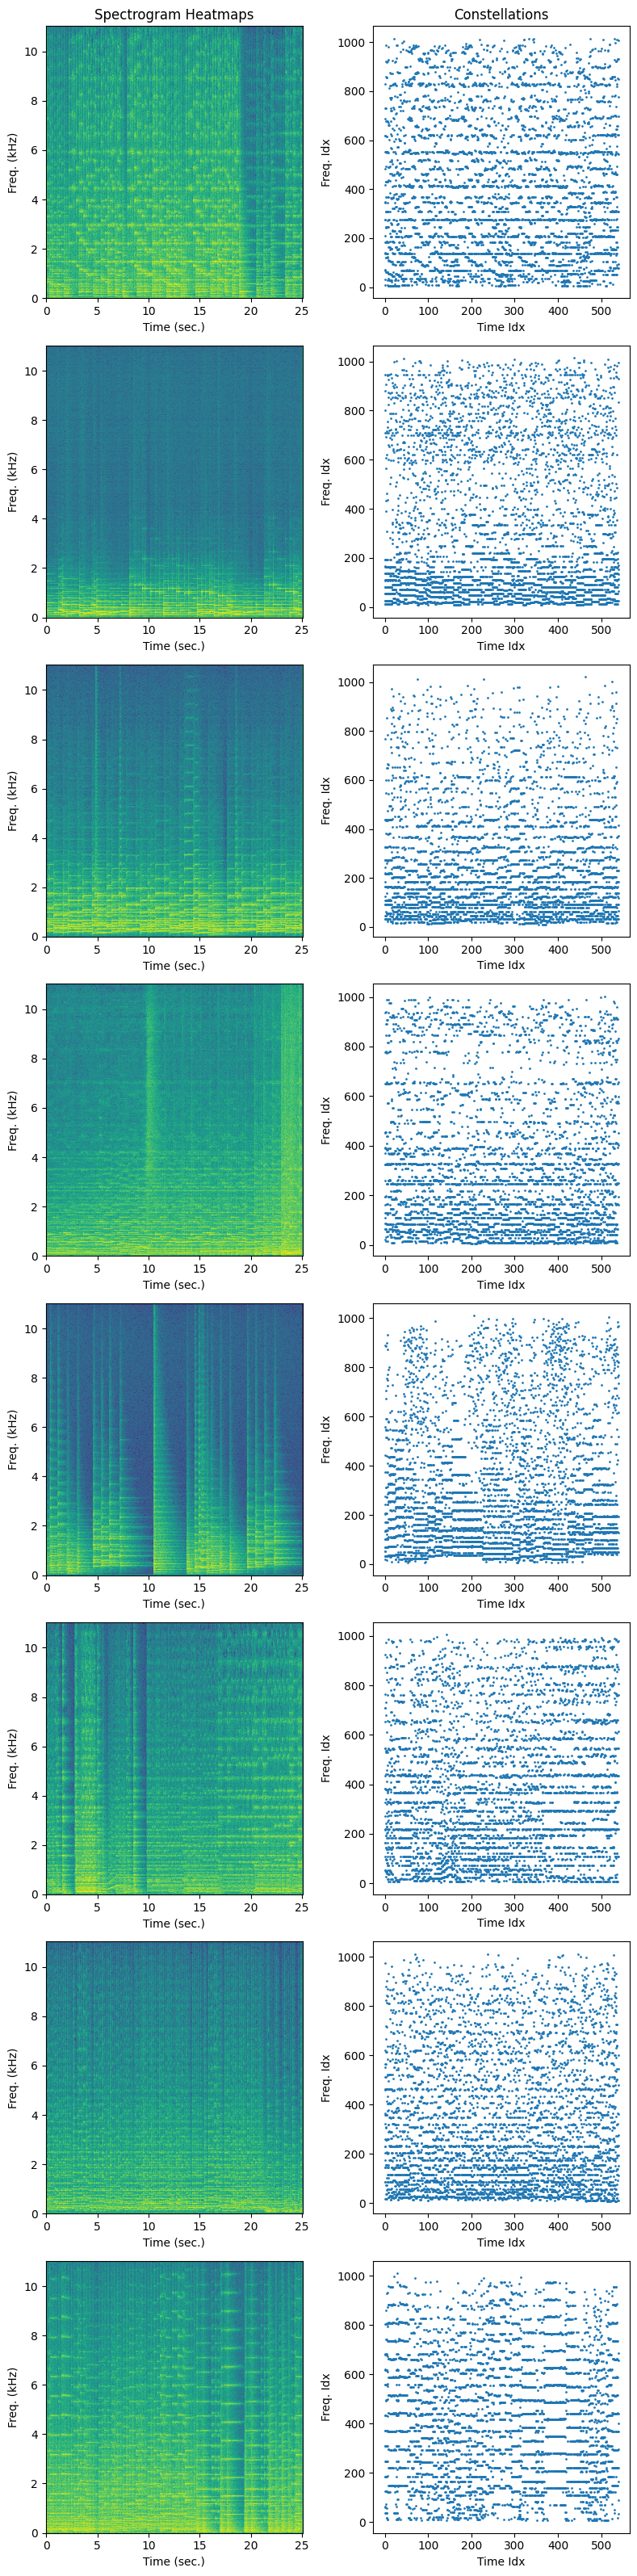

In [11]:
fig, axes = plt.subplots(nrows=num_plot_songs, ncols=2)
fig.set_size_inches(8.0, 4.0 * num_plot_songs)
for sidx, (name, signal) in enumerate(fils_to_signals.items()):
    if sidx >= num_plot_songs: break
    
    specto_power_db, freqs_hz, times_sec = create_specto(
        signal[:num_plot_samples],
        nfft,
        overlap_size,
        sample_rate_hz=target_sample_rate_hz, 
        log_scale=True
    )
    specto_constellation = create_constellation(
        specto_power_db, num_peaks, peak_detection_distance
    )
    axes[sidx][0].pcolormesh(times_sec, freqs_hz / 1e3, specto_power_db)
    axes[sidx][0].set_xlabel("Time (sec.)")
    axes[sidx][0].set_ylabel("Freq. (kHz)")
    
    axes[sidx][1].scatter(specto_constellation[:,0], specto_constellation[:,1], s=1)
    axes[sidx][1].set_xlabel("Time Idx")
    axes[sidx][1].set_ylabel("Freq. Idx")
    
    
axes[0][0].set_title("Spectrogram Heatmaps")
axes[0][1].set_title("Constellations")
fig.tight_layout()

## Hash Database Generation

Using the defined spectrogram _Constellation_ fingerprint's, we can build the  
Shazam `hash` indexable `database`. The Shazam `hash` acts a unique identifier  
to map granular spectral features to song lists that contain that given `hash`.  
The `hash` is built from combinatorial pairs of time-frequency coordinates  
across time using the _Constellation_ representation of the song. The Shazam  
`hash` is **not** the a single _Constellation_ coordinate. For example, a sample  
`hash` would be `(freq1, freq2, deltaT)`.

A configurable max duration in time is typically set to iterate combinatorial  
pairs and generate `hash`s for a given song.

The following plot shows a few unique `hash`s generated from combinatorial pairs  
for a single song's _Constellation_.

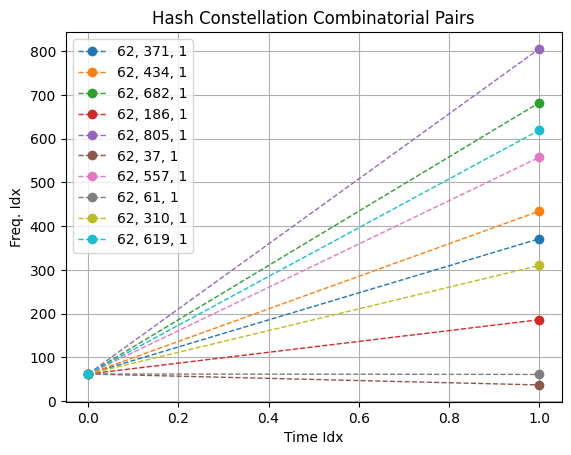

In [53]:
num_hash_plot_points: int = 10
count: int = 0

# This initial point acts as the "anchor point" to build combinatorial hash's 
# from within its Constellation target zone.
anchor_idx: int = 5
time1, freq1 = specto_constellation[anchor_idx]

plt.figure()
for (time2, freq2) in specto_constellation[
    anchor_idx + 1:anchor_idx + num_peaks + (anchor_idx % num_peaks)
]:
    time_diff = time2 - time1
    if time_diff <= 0:
        continue
    
    hash_label = f"{freq1}, {freq2}, {time_diff}"
    plt.plot(
        [time1, time2], 
        [freq1, freq2], 
        label=hash_label,
        marker="o",
        linestyle="--",
        linewidth=1.0
    )
    
    if count >= num_hash_plot_points:
        break
plt.grid()
plt.legend()
plt.xlabel("Time Idx")
plt.ylabel("Freq. Idx")
_ = plt.title("Hash Constellation Combinatorial Pairs")

The Shazam white paper additionally details how the total possible number of  
unique valued `hash`s can be determined by the frequency resolution used and the  
maximum delta time duration for the "target zone". For example, all unique `hash`s  
using 1024 frequency bins can represented using $2^{10} \cdot 2^{10} \cdot \Delta t$ values or  
$20 + bits(\Delta T)$ number of bits. This represents the 2 frequency indices and the  
difference in time between them.

Next using the unique `hash` identifiers generated from combinatorial  
_Constellation_ pairs of coordinates, a mapping from each `hash` to all songs can  
be made into a `hash` indexable `database`. 

The `combinatorial_distance` defines each "anchor points" target zone.

In [54]:
combinatorial_distance: int = 5

In [56]:
hash_key_type = int
hash_value_type = tuple[str, int]
database_type = dict[hash_key_type, list[hash_value_type]]

In [66]:
def create_hashes(
    specto_constellation: np.ndarray,
    distance: int,
    num_peaks: int,
    num_freq_bits: int = 10
) -> tuple[list[hash_key_type], list[int]]:
    hashes: list[hash_key_type] = []
    start_times: list[int] = []
    for c1_idx, (time1, freq1) in enumerate(specto_constellation):
        for (time2, freq2) in specto_constellation[
            c1_idx + 1:c1_idx + distance * num_peaks + (c1_idx % num_peaks)
        ]:
            
            time_diff = time2 - time1
            if time_diff > distance or time_diff <= 0:
                continue

            hash = freq1 | freq2 << num_freq_bits | time_diff << (num_freq_bits * 2)
            hashes.append(hash)
            start_times.append(time1)
    
    return hashes, start_times

In [68]:
database: database_type = {}
for sidx, (name, signal) in enumerate(fils_to_signals.items()):
    specto_power_db, _, _ = create_specto(
        signal[:num_plot_samples],
        nfft,
        overlap_size,
        sample_rate_hz=target_sample_rate_hz, 
        log_scale=True
    )
    specto_constellation = create_constellation(
        specto_power_db, num_peaks, peak_detection_distance
    )
    hashes, start_times = create_hashes(
        specto_constellation, combinatorial_distance, num_peaks
    )
    for hash, start_time in zip(hashes, start_times):
        if hash not in database:
            database[hash] = []
        database[hash].append((name, start_time))

print(f"Database Hash Size: {len(database)}")

Database Hash Size: 3018254


## Song Snippet Identification

...

In [ ]:
names = list(fils_to_signals.keys())
target_signal_name = np.random.choice(names)
signal = fils_to_signals[target_signal_name]
print(f"Target Signal Snippet: {target_signal_name}")

In [ ]:
snippet_duration: float = 15.0
snippet_num_samples: int = int(target_sample_rate_hz * snippet_duration)

random_start_idx = np.random.randint(0, signal.size - snippet_num_samples)
random_stop_idx = random_start_idx + snippet_num_samples
signal_snippet = signal[random_start_idx:random_stop_idx]

signal_snippet += np.random.normal(0.0, 100.0, size=signal_snippet.size)

sxx_power, freqs_hz, times_sec = create_specto(
    signal_snippet, target_sample_rate_hz, log_scale=True
)

plt.pcolormesh(times_sec, freqs_hz / 1e3, sxx_power)
plt.title(target_signal_name, fontsize=12)
plt.xlabel("Time (sec.)")
plt.ylabel("Freq. (kHz)")

In [ ]:
sxx_power, freqs_hz, times_sec = create_specto(signal_snippet, log_scale=False)
specto_constellation = create_constellation(sxx_power, num_peaks, distance)
hashes, start_times = create_hashes(
    specto_constellation, combinatorial_distance, num_peaks
)

matches = {}
for hash, start_time in zip(hashes, start_times):
    if hash not in database: continue
    for (database_name, database_start_time) in database[hash]:
        if database_name not in matches:
            matches[database_name] = 0
        matches[database_name] += 1

match_counts = list(matches.values())
match_names = list(matches.keys())
for idx, midx in enumerate(np.argsort(match_counts)[::-1]):
    print(f"\tMatch Name: {match_names[midx]}")
    print(f"\tMatch Count: {match_counts[midx]}")
    print()

That's pretty close odds ..., let's analyze the timing offset.

In [ ]:
matches_time_offsets: dict[str, list[int]] = {}
for hash, start_time in zip(hashes, start_times):
    if hash not in database: continue
    for (database_name, database_start_time) in database[hash]:
        if database_name not in matches_time_offsets:
            matches_time_offsets[database_name] = []
            
        matches_time_offsets[database_name].append(database_start_time - start_time)

In [ ]:
fig, axes = plt.subplots(num_rows, num_cols)
fig.set_size_inches(12.0, 12.0)
for idx, midx in enumerate(np.argsort(match_counts)[::-1]):
    if idx >= num_plot_samples:
        break
    match_name = match_names[midx]
    ridx = idx // num_cols
    cidx = idx % num_rows
    
    match_offsets = matches_time_offsets[match_name]
    axes[ridx][cidx].hist(match_offsets, bins=100)
    axes[ridx][cidx].set_title(match_name, fontsize=6)
    # axes[ridx][cidx].set_ylim([0.0, 90_000])
    # axes[ridx][cidx].set_xlabel("Time Idx")
    # axes[ridx][cidx].set_ylabel("Freq. Idx")
    
fig.tight_layout()